In [2]:
import numpy as np
import matplotlib.pyplot as plt

def ccw(A: np.ndarray, B: np.ndarray, C: np.ndarray) -> bool:
    return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])

def intersect(
    A: np.ndarray,
    B: np.ndarray,
    C: np.ndarray,
    D: np.ndarray) -> bool:
    """
    True if lines AB-CD intersect.
    """
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)
      
def ccw_batched(A: np.ndarray, B: np.ndarray, C: np.ndarray) -> bool:
    CA = C-A
    BA = B-A
    return (CA[:,:,1]) * (BA[:,:,0]) > (BA[:,:,1]) * (CA[:,:,0])

def intersect_batched(
    A: np.ndarray,
    B: np.ndarray,
    C: np.ndarray,
    D: np.ndarray) -> bool:
    """
    True if lines AB-CD intersect.
    """
    return (
        (ccw_batched(A,C,D) != ccw_batched(B,C,D)) &
        (ccw_batched(A,B,C) != ccw_batched(A,B,D))
        )
      
def quad_batched(
    A: np.ndarray,
    B: np.ndarray,
    C: np.ndarray,
    D: np.ndarray) -> bool:
    """
    True if lines ABCD 
    """
    c1 = intersect_batched(A, B, C, D)
    c2 = intersect_batched(B, C, D, A)
    # print(c1)
    # print(c2)
    return (c1 | c2)

def quad_batched_opt(
    A: np.ndarray,
    B: np.ndarray,
    C: np.ndarray,
    D: np.ndarray) -> bool:
    """
    True if lines ABCD 
    """
    
    D_A = D - A
    D_B = D - B
    C_A = C - A
    C_B = C - B
    B_A = B - A
    D_C = D - C
    B_C = - C_B
            
    # Counter Clockwise
    ccw_ACD = (D_A[:, :, 1] * C_A[:, :, 0] > C_A[:, :, 1] * D_A[:, :, 0])
    ccw_BCD = (D_B[:, :, 1] * C_B[:, :, 0] > C_B[:, :, 1] * D_B[:, :, 0])
    ccw_ABC = (C_A[:, :, 1] * B_A[:, :, 0] > B_A[:, :, 1] * C_A[:, :, 0])
    ccw_ABD = (D_A[:, :, 1] * B_A[:, :, 0] > B_A[:, :, 1] * D_A[:, :, 0])
    ccw_CBD = (D_C[:, :, 1] * B_C[:, :, 0] > B_C[:, :, 1] * D_C[:, :, 0])
    ccw_ACB = (B_A[:, :, 1] * C_A[:, :, 0] > C_A[:, :, 1] * B_A[:, :, 0])
    
    # Checks
    check1 = (ccw_ACD != ccw_BCD) & (ccw_ABC != ccw_ABD)
    check2 = (ccw_ABD != ccw_CBD) & (ccw_ACB != ccw_ACD)

    res = (check1 | check2).squeeze()
    return res

(1, 4, 3)


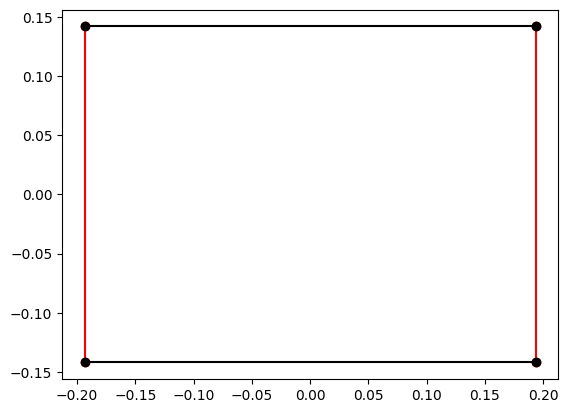

[[False]]


In [55]:
ABCD = np.array([[[ 0.1934,      0.142,       0.02519415],
  [ 0.1934,     -0.142,       0.02519415],
  [-0.1934,      0.142,       0.02519415],
  [-0.1934,     -0.142,       0.02519415],]])
print(ABCD.shape)
ABCD = ABCD.reshape((4, 1, 3))
A,B,C,D = np.split(ABCD, 4, axis=0)

BCAD = np.concatenate([A, C, B, D])

plt.plot(ABCD[:2, 0, 0], ABCD[:2, 0, 1], ABCD[2:, 0, 0], ABCD[2:, 0, 1], marker="o", c='r')
plt.plot(BCAD[:2, 0, 0], BCAD[:2, 0, 1], BCAD[2:, 0, 0], BCAD[2:, 0, 1], marker="o", c='k')
plt.show()

res = intersect_batched(A, B, C, D) | intersect_batched(A, C, B, D)
print(res)

In [25]:
ABCD = np.random.rand(8, 3)
A,B,C,D = np.split(ABCD, 4)

N = 1200

def f1():
    ABCD = np.random.rand(4, N, 3)
    A,B,C,D = np.split(ABCD, 4)

    res = intersect_batched(A[:, :2], B[:, :2], C[:, :2], D[:, :2])
    return res

def f2():
    res = []
    for _ in range(N):
        ABCD = np.random.rand(4, 2)
        A,B,C,D = np.split(ABCD, 4)

        r = intersect(A[0], B[0], C[0], D[0])
        res.append(r)
        
    return res
 
%timeit f1()
%timeit f2()


73.1 µs ± 128 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
11.3 ms ± 276 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [56]:

N = 800

def f3():
    ABCD = np.random.rand(4, N, 2)
    A,B,C,D = np.split(ABCD, 4)
    
    res = quad_batched(A, B, C, D)
    return res

def f4():
    ABCD = np.random.rand(4, N, 2)
    A,B,C,D = np.split(ABCD, 4)
    
    res = quad_batched_opt(A, B, C, D)
    return res

%timeit f3()
%timeit f4()

79.2 µs ± 920 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
61.9 µs ± 423 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [57]:
ABCD = np.array([[[ 0.1934,      0.142,       0.02519415],
  [ 0.1934,     -0.142,       0.02519415],
  [-0.1934,      0.142,       0.02519415],
  [-0.1934,     -0.142,       0.02519415],]])
print(ABCD.shape)
ABCD = ABCD.reshape((4, 1, 3))

A,B,C,D = np.split(ABCD, 4, axis=0)

res = quad_batched_opt(A, B, C, D)
print(res)


(1, 4, 3)
False


In [95]:
N = 1000
data = [(bool(np.random.randint(2)), np.random.random(18)) for _ in range(N)]

def f6():
    bool_list, array_list = zip(*data)
    bool_array = np.array(bool_list, dtype=bool)
    array = np.array(array_list)
    array = array[bool_array]
    
    return bool_array, array

def f7():
    # Split into two separate lists using list comprehensions
    bool_list = [item[0] for item in data]
    array_list = [item[1] for item in data if item[0]]

    # Convert the lists to NumPy arrays
    bool_array = np.array(bool_list)
    array = np.array(array_list)
    
    return bool_array, array


%timeit f6
%timeit f7

10.3 ns ± 0.0417 ns per loop (mean ± std. dev. of 7 runs, 100,000,000 loops each)
10.4 ns ± 0.0929 ns per loop (mean ± std. dev. of 7 runs, 100,000,000 loops each)


In [21]:
from itertools import permutations
N = 10

def f8():
    loc = np.random.rand(N, 3)
    combin = np.array(list(permutations(loc, 4)))
    return combin

def f9():
    loc = np.random.rand(N, 3)
    combin = np.fromiter(permutations(loc, 4), dtype=np.float64)
    return combin

%timeit f8()
%timeit f9()

3.1 ms ± 5.99 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


ValueError: setting an array element with a sequence.

In [32]:
id = np.random.randint(0, N, size=(N))
loc = np.random.rand(N, 3)
combin = np.array(list(permutations(id, 4)))
combin.shape

loc_feet = loc[combin]
print(loc_feet.shape)

(5040, 4, 3)


In [38]:
m = np.argmin(loc)

In [51]:
loc = np.random.rand(N, 3)

contact_plan = np.array([
    [1, 1, 1, 1],
    [2, 2, 2, 2],
])

contact_plan_loc = loc[contact_plan]

print(contact_plan_loc)
full_contact_plan = np.repeat(contact_plan_loc, 2, axis=0)
print(full_contact_plan)

[[[0.58284866 0.73344723 0.51561825]
  [0.58284866 0.73344723 0.51561825]
  [0.58284866 0.73344723 0.51561825]
  [0.58284866 0.73344723 0.51561825]]

 [[0.6800672  0.06177429 0.96878486]
  [0.6800672  0.06177429 0.96878486]
  [0.6800672  0.06177429 0.96878486]
  [0.6800672  0.06177429 0.96878486]]]
[[[0.58284866 0.73344723 0.51561825]
  [0.58284866 0.73344723 0.51561825]
  [0.58284866 0.73344723 0.51561825]
  [0.58284866 0.73344723 0.51561825]]

 [[0.58284866 0.73344723 0.51561825]
  [0.58284866 0.73344723 0.51561825]
  [0.58284866 0.73344723 0.51561825]
  [0.58284866 0.73344723 0.51561825]]

 [[0.6800672  0.06177429 0.96878486]
  [0.6800672  0.06177429 0.96878486]
  [0.6800672  0.06177429 0.96878486]
  [0.6800672  0.06177429 0.96878486]]

 [[0.6800672  0.06177429 0.96878486]
  [0.6800672  0.06177429 0.96878486]
  [0.6800672  0.06177429 0.96878486]
  [0.6800672  0.06177429 0.96878486]]]


In [5]:
from operator import itemgetter
N = 2000

def argmax1():
    h = np.random.rand(N).tolist()
    index, _ = max(enumerate(h), key=itemgetter(1))
    
    return index

def argmax2():
    h = np.random.rand(N).tolist()
    index = np.argmax(h)
    
    return index

%timeit argmax1()
%timeit argmax2()

83.1 µs ± 671 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
68.1 µs ± 196 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
